# Logistic Regression

In [1]:
import torch
from fastai.vision.all import *
from utils import load_dataset
import copy

## Dataset

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y = load_dataset()
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)

torch.Size([209, 64, 64, 3])
torch.Size([1, 209])
torch.Size([50, 64, 64, 3])
torch.Size([1, 50])


torch.Size([64, 64, 3])

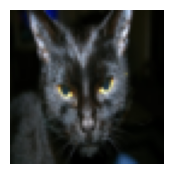

In [3]:
img_t = train_set_x_orig[25]
show_image(img_t)
img_t.shape

In [4]:
# Process each channel separately
channels = ['Reds', 'Greens', 'Blues']
for i, color in enumerate(channels):
    # Extract one color channel
    channel_data = img_t[0:20,0:20, i]

    # Convert to DataFrame
    df = pd.DataFrame(channel_data)

    # You can apply styling and display each channel
    display(df.style.set_properties(**{'font-size':'4pt'}).background_gradient(color, axis=None))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15,17,17,11,7,5,15,32,46,36,28,22,18,21,36,10,2,2,3,12
1,16,18,19,15,10,6,9,38,68,63,38,26,23,23,22,16,4,2,2,11
2,16,18,21,19,13,7,6,34,86,105,67,39,30,26,19,20,24,4,3,13
3,15,18,21,21,15,8,5,31,97,126,95,59,43,34,26,17,29,24,16,20
4,13,16,20,19,13,7,5,24,95,144,124,87,57,45,41,27,18,35,59,49
5,9,14,19,17,9,6,6,15,84,164,154,107,74,64,54,45,21,18,51,71
6,6,12,18,15,7,4,6,12,79,170,156,103,94,72,57,54,33,15,25,54
7,4,10,17,15,7,4,6,8,54,149,167,118,82,70,63,54,47,23,20,32
8,3,10,17,15,8,6,8,7,24,119,165,131,78,81,87,66,51,43,20,26
9,3,9,16,16,10,8,8,7,10,76,142,120,82,75,97,88,53,49,35,23


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15,17,17,11,7,6,18,32,48,37,27,20,16,20,40,23,14,10,9,17
1,16,17,18,13,9,7,14,38,71,70,38,23,19,18,22,28,19,12,11,17
2,16,17,19,15,10,8,12,35,90,121,72,37,26,21,17,23,35,16,12,19
3,15,17,19,16,11,8,9,33,99,144,107,60,37,27,20,16,33,32,25,25
4,13,16,19,16,10,8,8,27,94,158,139,94,54,37,29,23,18,37,63,55
5,10,15,19,16,9,7,10,22,84,173,167,118,79,61,45,38,18,18,52,75
6,7,13,19,15,8,6,9,18,81,176,165,108,105,76,52,50,27,15,26,55
7,5,11,18,15,7,5,8,12,56,150,170,121,89,74,61,48,40,20,19,31
8,3,10,18,16,9,10,13,12,28,115,161,138,84,88,90,62,41,35,18,25
9,3,9,17,17,13,14,16,15,15,75,138,121,84,80,105,89,44,38,30,22


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,5,6,7,6,7,13,27,29,53,36,21,12,8,14,75,118,113,87,67,51
1,5,6,9,10,13,21,36,38,79,78,34,16,10,9,25,103,122,98,73,52
2,6,8,9,11,16,25,44,41,103,144,77,33,18,11,8,38,106,92,69,51
3,7,8,9,10,14,21,34,46,112,170,124,63,31,16,9,9,49,82,72,54
4,5,7,9,9,10,15,28,48,106,185,161,106,52,28,18,13,11,44,84,75
5,4,7,9,7,6,9,24,45,92,199,188,133,87,60,38,29,9,12,53,81
6,3,6,10,7,5,5,18,36,91,197,180,116,118,78,47,44,18,7,21,56
7,2,6,10,7,4,3,10,19,62,164,182,129,97,77,60,40,32,10,11,26
8,2,5,10,8,4,6,11,12,30,122,165,149,88,99,98,59,30,24,10,16
9,1,5,11,9,7,10,14,14,16,78,140,123,85,87,118,94,36,25,20,14


In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print('Number of training examples: m_train = ' + str(m_train))
print('Number of testing examples: m_test = ' + str(m_test))
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
train_set_x shape: torch.Size([209, 64, 64, 3])
train_set_y shape: torch.Size([1, 209])
test_set_x shape: torch.Size([50, 64, 64, 3])
test_set_y shape: torch.Size([1, 50])


In [6]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

# Check that the first 10 pixels of the second image are in the correct place
assert torch.all(torch.eq(train_set_x_flatten[0:10, 1], torch.tensor([196, 192, 190, 193, 186, 182, 188, 179, 174, 213]))), "Wrong solution. Use (X.shape[0], -1).T."
assert torch.all(torch.eq(test_set_x_flatten[0:10, 1], torch.tensor([115, 110, 111, 137, 129, 129, 155, 146, 145, 159]))), "Wrong solution. Use (X.shape[0], -1).T."


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: torch.Size([12288, 209])
train_set_y shape: torch.Size([1, 209])
test_set_x_flatten shape: torch.Size([12288, 50])
test_set_y shape: torch.Size([1, 50])


Let's standardize our dataset.

In [7]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

# Model

In [8]:
def initialize_params_zeros(dim):
    w = torch.zeros(dim, 1, requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w, b

def initialize_params_random(dim):
    w = torch.randn(dim, 1, requires_grad=True)
    b = torch.randn(1, requires_grad=True)
    return w, b

# quick test
dim = 2
w, b = initialize_params_random(dim)
print("w = " + str(w))
print ("b = " + str(b))


w = tensor([[-0.9651],
        [-0.6708]], requires_grad=True)
b = tensor([-0.5353], requires_grad=True)


In [9]:
def loss_function(y_hat, y):
    loss = -y * torch.log(y_hat) - (1 - y) * torch.log(1 - y_hat)
    return loss

In [10]:
def propagate(w, b, X, Y):
    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    z = w.T@X + b  # linear function
    A = z.sigmoid() # compute activation
    loss = loss_function(A, Y)  # compute loss
    cost = 1 / m * torch.sum(loss)  # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    # loss.backward() # backward must be computed on scalar (i.e. cost) not a vector (i.e. loss)
    cost.backward()

    # Get rid of these later and change to torch_dw and torch_db
    dw = w.grad
    db = b.grad


    grads = {"dw": dw,
             "db": db,
            }

    return grads, cost

In [11]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)

        # Note: The .data is a special attribute in pytorch where the gradient is not computed when used.
        w.data -= learning_rate * w.grad.data
        b.data -= learning_rate * b.grad.data
        w.grad.zero_()
        b.grad.zero_()

        # Record the costs
        if i % 100 == 0:
            costs.append(cost.item())  # Append the scalar value
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost.item()))

    params = {"w": w, "b": b}
    grads = {"dw": w.grad, "db": b.grad}

    return params, grads, costs


In [12]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = torch.zeros((1, m))
    z = w.T@X + b  # linear function
    A = z.sigmoid() # compute activation

    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0,i] = 0
    
    return Y_prediction

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    dim = X_train.shape[0]
    # w, b = initialize_params_random(dim)
    w, b = initialize_params_zeros(dim)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = params['w']
    b = params['b']
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - torch.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - torch.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": torch.tensor(costs),
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [14]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306030273438 %
test accuracy: 70.0 %


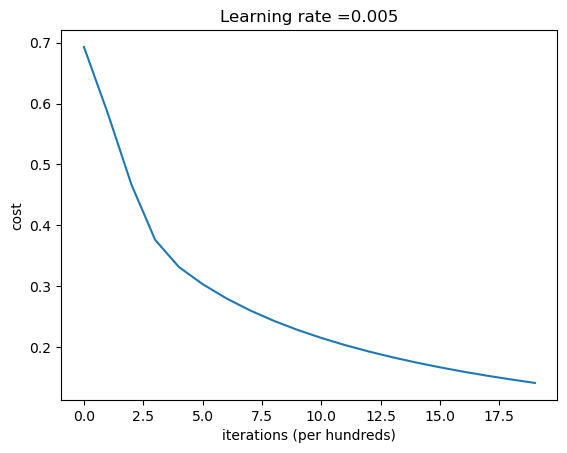

In [15]:
# Plot learning curve (with costs)
costs = torch.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

y = tensor(1), you predicted that it is a "1" picture.


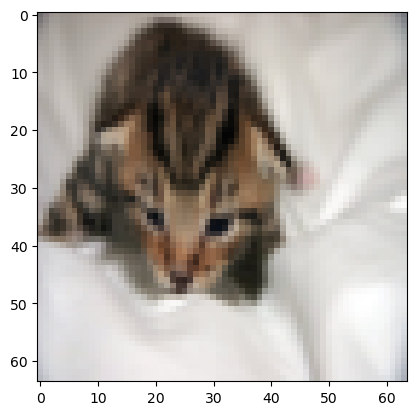

In [16]:
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + str(int(logistic_regression_model['Y_prediction_test'][0,index])) +  "\" picture.")

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



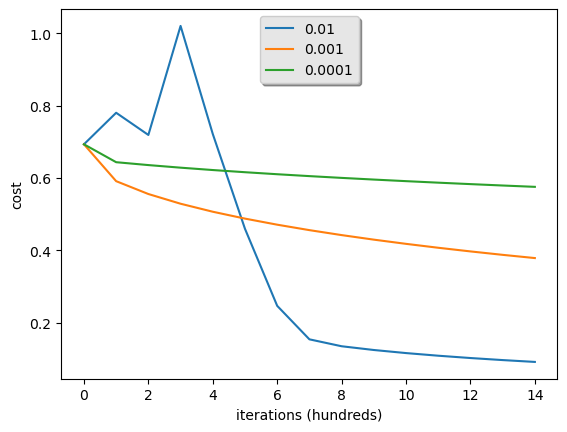

In [17]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()